# Time Series Traditional Analysis
### Modeling with Moving Average
We'll use the differenced series to model with moving average (MA) and exponential moving average.

In [2]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings

warnings.filterwarnings("ignore")

merged_df = pd.read_csv('../data/merged_df.csv', parse_dates=['timestamp'], index_col='timestamp').sort_index().convert_dtypes()
t_df = pd.read_csv('../data/t.csv', parse_dates=['timestamp'], index_col='timestamp').sort_index().convert_dtypes()
v_df = pd.read_csv('../data/v.csv', parse_dates=['timestamp'], index_col='timestamp').sort_index().convert_dtypes()

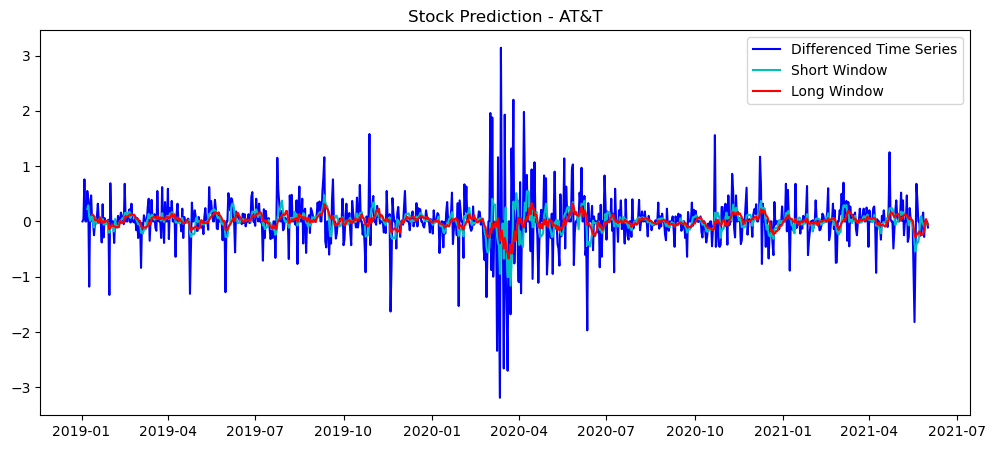

In [3]:
fig, ax = plt.subplots(figsize=(12, 5)) 
ax.plot(merged_df.t_diff, label="Differenced Time Series", c='b')
ax.plot(merged_df.t_diff.rolling(window=6).mean(), label = "Short Window", c='c')
ax.plot(merged_df.t_diff.rolling(window=11).mean(), label="Long Window", c='r')
ax.legend(loc="best")
ax.set_title("Stock Prediction - AT&T")
plt.show()

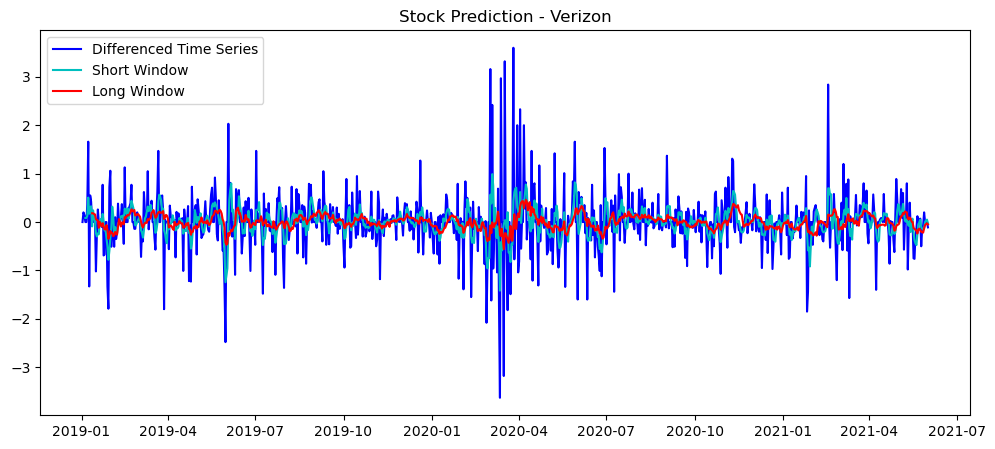

In [4]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(merged_df.v_diff, label="Differenced Time Series", c="b")
ax.plot(merged_df.v_diff.rolling(window=4).mean(), label="Short Window", c="c")
ax.plot(merged_df.v_diff.rolling(window=11).mean(), label="Long Window", c="r")
ax.legend(loc="best")
ax.set_title("Stock Prediction - Verizon")
plt.show()

In [5]:
# Calculate the moving average

merged_df = merged_df.assign(t_ma_short = merged_df.t_diff.rolling(window=6).mean())
merged_df = merged_df.assign(t_ma_long = merged_df.t_diff.rolling(window=11).mean())
merged_df = merged_df.assign(v_ma_short = merged_df.v_diff.rolling(window=4).mean())
merged_df = merged_df.assign(v_ma_long = merged_df.v_diff.rolling(window=11).mean())
merged_df = merged_df.fillna(0)

In [6]:
def rmse(y,y_hat):
    return np.sqrt(mean_squared_error(y, y_hat))

In [7]:
print(f"AT&T Short-Window MA RMSE: {rmse(merged_df.t_diff, merged_df.t_ma_short):.4f}")
print(f"AT&T Long-Window MA RMSE: {rmse(merged_df.t_diff, merged_df.t_ma_long):.4f}")
print(f"Verizon Short-Window MA RMSE: {rmse(merged_df.v_diff, merged_df.v_ma_short):.4f}")
print(f"Verizon Long-Window MA RMSE: {rmse(merged_df.v_diff, merged_df.v_ma_long):.4f}")

AT&T Short-Window MA RMSE: 0.4202
AT&T Long-Window MA RMSE: 0.4415
Verizon Short-Window MA RMSE: 0.5254
Verizon Long-Window MA RMSE: 0.5714


### Modeling with EWM
We'll use the differenced series to model with exponential moving average.

In [8]:
t_ewm = merged_df.t_diff.ewm(span=11, adjust=False).mean()

In [9]:
# Calculate the exponential weighted average
merged_df = merged_df.assign(t_ewm_short=merged_df.t_diff.ewm(span=6, adjust=False).mean())
merged_df = merged_df.assign(t_ewm_long=merged_df.t_diff.ewm(span=11, adjust=False).mean())
merged_df = merged_df.assign(v_ewm_short=merged_df.v_diff.ewm(span=4, adjust=False).mean())
merged_df = merged_df.assign(v_ewm_long=merged_df.v_diff.ewm(span=11, adjust=False).mean())

In [10]:
print(f"AT&T Short-Window EWM RMSE: {rmse(merged_df.t_diff, merged_df.t_ewm_short):.4f}")
print(f"AT&T Long-Window EWM RMSE: {rmse(merged_df.t_diff, merged_df.t_ewm_long):.4f}")
print(f"Verizon Short-Window EWM RMSE: {rmse(merged_df.v_diff, merged_df.v_ewm_short):.4f}")
print(f"Verizon Long-Window EWM RMSE: {rmse(merged_df.v_diff, merged_df.v_ewm_long):.4f}")

AT&T Short-Window EWM RMSE: 0.3570
AT&T Long-Window EWM RMSE: 0.4008
Verizon Short-Window EWM RMSE: 0.4077
Verizon Long-Window EWM RMSE: 0.5221


The EWM outperforms the simple moving average because the EWM gives more weight to recent data points while still considering the older data, giving it the ability to reflect changes quickly. 

### Modeling with Autoregressive

In [11]:
# Separating the differenced time series off into their own DataFrames for convenience
t_diff = merged_df.t_diff.asfreq("D")
v_diff = merged_df.v_diff.asfreq("D")

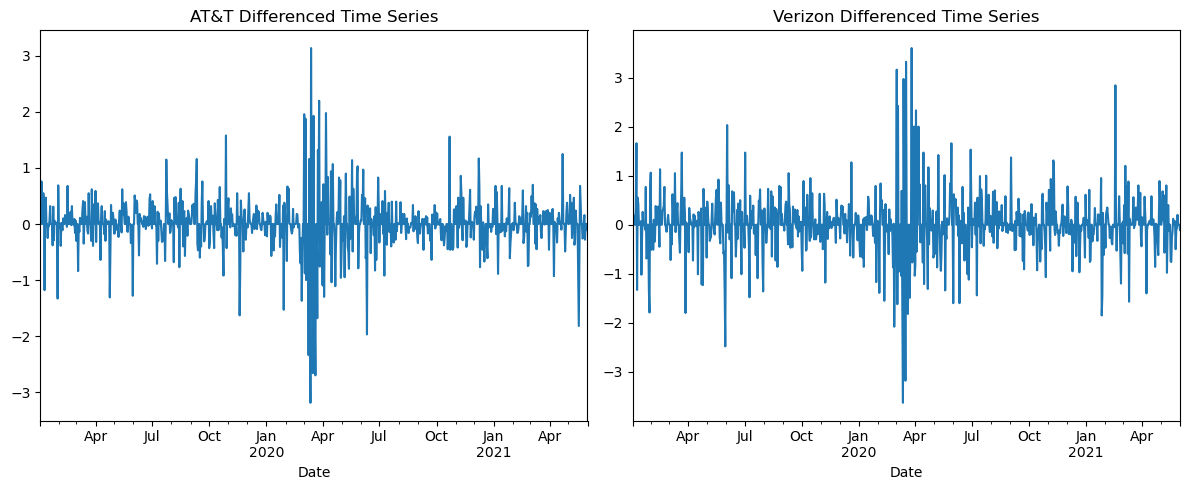

In [12]:
# Let's look at the differenced data.
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns of subplots

# Plot ACF for AT&T Differenced Series
t_diff.plot(title="AT&T Differenced Time Series", ax=ax[0])
ax[0].set_xlabel("Date")

# Plot ACF for Verizon Differenced Series
v_diff.plot(title="Verizon Differenced Time Series", ax=ax[1])
ax[1].set_xlabel("Date")

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

In [13]:
# Let's reconfirm that both time series are stationary using the Augmented Dickey-Fuller test.
t_adf = adfuller(t_diff)
v_adf = adfuller(v_diff)

print(f'AT&T ADF Statistic: {t_adf[0]}')
print(f'AT&T p-value: {t_adf[1]}')
print(f'Verizon ADF Statistic: {v_adf[0]}')
print(f'Verizon p-value: {v_adf[1]}')

AT&T ADF Statistic: -7.6543356110327725
AT&T p-value: 1.7552464348369084e-11
Verizon ADF Statistic: -7.428178984000126
Verizon p-value: 6.465083459795888e-11


Both datasets have ADF p-values << 0.05, so we can reject the null hypothesis and conclude that both datasets are stationary. Let's plot the ACF again to see whether there is autocorrelation.

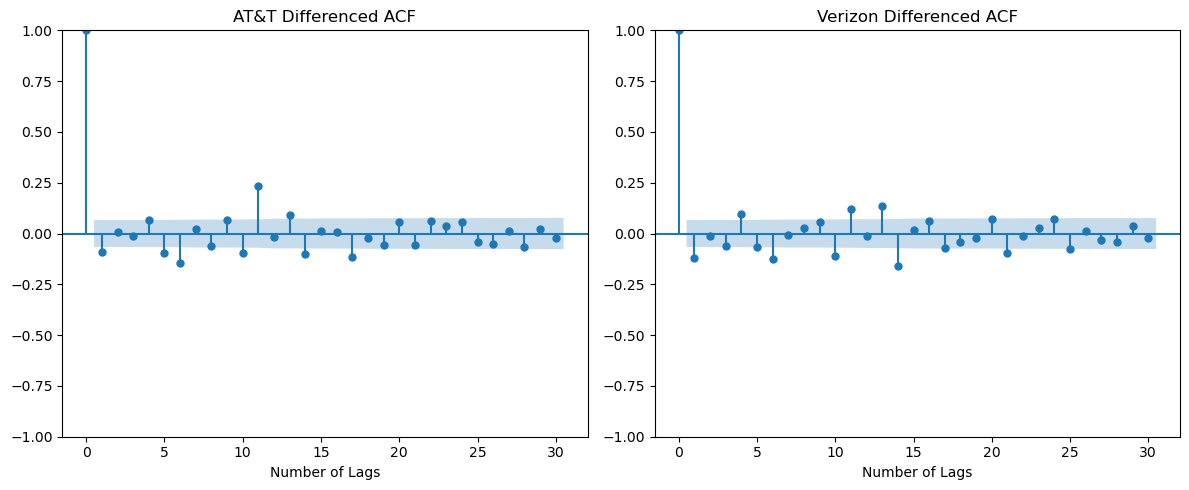

In [14]:
# Plot ACF for the differenced time series
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns of subplots

# Plot ACF for AT&T Differenced Series
plot_acf(t_diff, lags=30, title="AT&T Differenced ACF", ax=ax[0])
ax[0].set_xlabel("Number of Lags")

# Plot ACF for Verizon Differenced Series
plot_acf(v_diff, lags=30, title="Verizon Differenced ACF", ax=ax[1])
ax[1].set_xlabel("Number of Lags")

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

A gradually decreasing ACF plot would suggest an autoregressive model. This isn't exactly the case, but it looks like there isn't a clear MA(q) model either. Let's plot the PACF to see if we can determine the order of the AR model.

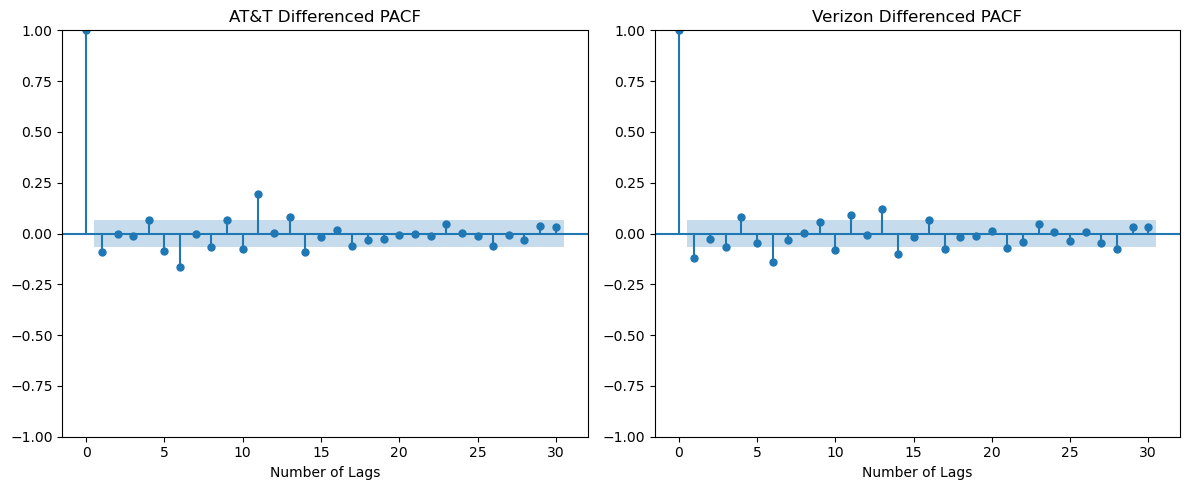

In [15]:
# Plot PACF for the differenced time series
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns of subplots

# Plot ACF for AT&T Differenced Series
plot_pacf(t_diff, lags=30, title="AT&T Differenced PACF", ax=ax[0])
ax[0].set_xlabel("Number of Lags")

# Plot ACF for Verizon Differenced Series
plot_pacf(v_diff, lags=30, title="Verizon Differenced PACF", ax=ax[1])
ax[1].set_xlabel("Number of Lags")

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

This looks like an `AR(1)` or `AR(2)` model for both datasets, though there appears to be some seasonality in both plots. We can look at ARIMA or SARIMA models later to account for this. In the meantime, let's split the data into training and testing sets.

In [16]:
# Splitting the data into training and testing sets
# Make sure both datasets are the same length to use a single split point
assert len(t_diff) == len(v_diff)

# Creating split points to maintain temporal integrity
split_point = int(len(t_diff) * 0.95)

t_train = t_diff.iloc[:split_point]
t_test = t_diff.iloc[split_point:]
v_train = v_diff.iloc[:split_point]
v_test = v_diff.iloc[split_point:]

In [17]:
  # Let's check the lengths of the training and testing sets.
  print(f'AT&T Training Set Length: {len(t_train)}')
  print(f'AT&T Test Set Length: {len(t_test)}')
  print(f'Verizon Training Set Length: {len(v_train)}')
  print(f'Verizon Test Set Length: {len(v_test)}')

AT&T Training Set Length: 837
AT&T Test Set Length: 45
Verizon Training Set Length: 837
Verizon Test Set Length: 45


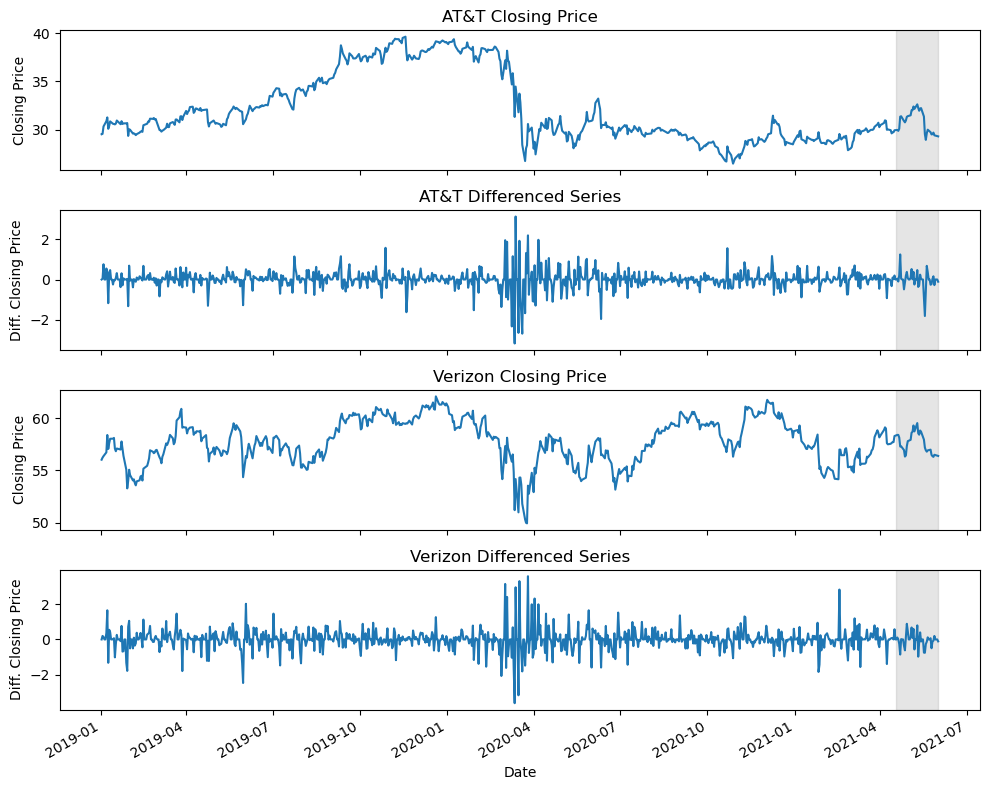

In [18]:
# Let's visualize the testing scenario for AT&T and Verizon.
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True,
                               figsize=(10, 8))

ax1.plot(t_df.close, label='AT&T Closing Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Price')
ax1.axvspan(merged_df['close_t'].index[split_point], t_df.index[-1],
            color='#808080', alpha=0.2)
ax1.set_title('AT&T Closing Price')

ax2.plot(t_diff, label='AT&T Diff. Closing Price')
ax2.set_xlabel('Date')
ax2.set_ylabel('Diff. Closing Price')
ax2.axvspan(t_diff.index[split_point], t_df.index[-1],
            color='#808080', alpha=0.2)
ax2.set_title('AT&T Differenced Series')

ax3.plot(v_df.close, label='Verizon Closing Price')
ax3.set_xlabel('Date')
ax3.set_ylabel('Closing Price')
ax3.axvspan(merged_df['close_v'].index[split_point], v_df.index[-1],
            color='#808080', alpha=0.2)
ax3.set_title('Verizon Closing Price')

ax4.plot(v_diff, label='Verizon Diff. Closing Price')
ax4.set_xlabel('Date')
ax4.set_ylabel('Diff. Closing Price')
ax4.axvspan(v_diff.index[split_point], v_df.index[-1],
            color='#808080', alpha=0.2)
ax4.set_title('Verizon Differenced Series')

fig.autofmt_xdate()
plt.tight_layout()

In [19]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_predict

t_ar = AutoReg(t_train, lags=11)
v_ar = AutoReg(v_train, lags=6)
t_ar_fit = t_ar.fit()
v_ar_fit = v_ar.fit()

In [20]:
t_ar_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 t_diff   No. Observations:                  837
Model:                    AutoReg(11)   Log Likelihood                -474.243
Method:               Conditional MLE   S.D. of innovations              0.430
Date:                Mon, 13 Jan 2025   AIC                            974.487
Time:                        17:47:07   BIC                           1035.802
Sample:                    01-13-2019   HQIC                           998.006
                         - 04-17-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.015     -0.105      0.916      -0.031       0.028
t_diff.L1     -0.1019      0.034     -2.990      0.003      -0.169      -0.035
t_diff.L2     -0.0114      0.034     -0.332      0.740      -0.078       0.056
t_diff.L3      0.0219      0.034      0.642      0.521      -0.045       0.089
t_diff.L4      0.0683      0.034      2.010      0.044       0.002       0.135
t_diff.L5     -0.0756      0.034     -2.221      0.026      -0.142      -0.009
t_diff.L6     -0.1622      0.034     -4.824      0.000      -0.228      -0.096
t_diff.L7     -0.0472      0.034     -1.388      0.165      -0.114       0.019
t_diff.L8     -0.0532      0.034     -1.568      0.117      -0.120       0.013
t_diff.L9      0.0749      0.034      2.210      0.027       0.008       0.141
t_diff.L10    -0.0483      0.034     -1.416      0.157      -0.115       0.019
t_diff.L11     0.1987      0.034      5.852      0.000       0.132       0.265
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0409           -0.3294j            1.0917           -0.4512
AR.2            -1.0409           +0.3294j            1.0917            0.4512
AR.3            -0.7369           -0.9069j            1.1686           -0.3586
AR.4            -0.7369           +0.9069j            1.1686            0.3586
AR.5            -0.1298           -1.1347j            1.1421           -0.2681
AR.6            -0.1298           +1.1347j            1.1421            0.2681
AR.7             0.9532           -0.5868j            1.1194           -0.0878
AR.8             0.9532           +0.5868j            1.1194            0.0878
AR.9             1.2431           -0.0000j            1.2431           -0.0000
AR.10            0.4543           -1.1470j            1.2337           -0.1900
AR.11            0.4543           +1.1470j            1.2337            0.1900
------------------------------------------------------------------------------
"""

In [21]:
v_ar_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 v_diff   No. Observations:                  837
Model:                     AutoReg(6)   Log Likelihood                -735.494
Method:               Conditional MLE   S.D. of innovations              0.586
Date:                Mon, 13 Jan 2025   AIC                           1486.987
Time:                        17:47:07   BIC                           1524.768
Sample:                    01-08-2019   HQIC                          1501.475
                         - 04-17-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.020      0.127      0.899      -0.037       0.042
v_diff.L1     -0.1282      0.034     -3.739      0.000      -0.195      -0.061
v_diff.L2     -0.0229      0.035     -0.663      0.507      -0.091       0.045
v_diff.L3     -0.0643      0.034     -1.866      0.062      -0.132       0.003
v_diff.L4      0.0692      0.034      2.009      0.045       0.002       0.137
v_diff.L5     -0.0675      0.035     -1.956      0.050      -0.135       0.000
v_diff.L6     -0.1491      0.034     -4.345      0.000      -0.216      -0.082
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1665           -0.7306j            1.3764           -0.0890
AR.2            1.1665           +0.7306j            1.3764            0.0890
AR.3           -0.0680           -1.3061j            1.3079           -0.2583
AR.4           -0.0680           +1.3061j            1.3079            0.2583
AR.5           -1.3250           -0.5608j            1.4388           -0.4363
AR.6           -1.3250           +0.5608j            1.4388            0.4363
-----------------------------------------------------------------------------
"""

In [22]:
# Predict the last 5% of the time series
assert len(t_train) == len(v_train)
pred_start = len(t_train)
pred_end = len(t_train) + len(t_test) - 1
t_predictions = t_ar_fit.predict(start=pred_start, end=pred_end)
v_predictions = v_ar_fit.predict(start=pred_start, end=pred_end)

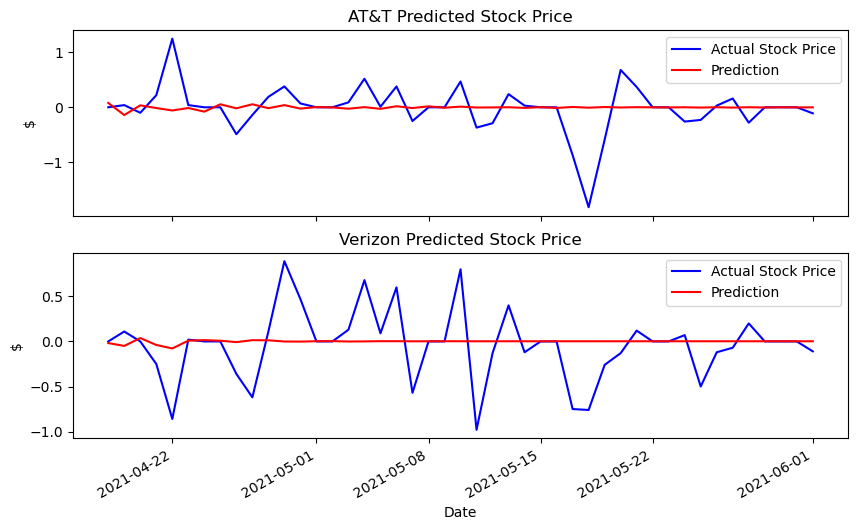

In [23]:
# Visualize the predictions
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))


ax1.plot(t_test, label='Actual Stock Price', c='b')
ax1.plot(t_predictions, c='r', label='Prediction')
ax1.set_title('AT&T Predicted Stock Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('$')
ax1.legend()

ax2.plot(v_test, label='Actual Stock Price', c='b')
ax2.plot(v_predictions, c='r', label='Prediction')
ax2.set_title('Verizon Predicted Stock Price')
ax2.set_xlabel('Date')
ax2.set_ylabel('$')
ax2.legend()

fig.autofmt_xdate()
plt.show()

In [24]:
print('RMSE of AT&T AR model {:.4f}'
      .format(rmse(t_test, t_predictions)))
print('RMSE of Verizon AR model {:.4f}'
      .format(rmse(v_test, v_predictions)))

RMSE of AT&T AR model 0.4337
RMSE of Verizon AR model 0.3879


### Modeling with ARIMA (Autoregressive Integrated Moving Average)
We'll use the ARIMA model to forecast the differenced series. The ARIMA model is a generalization of an autoregressive moving average (ARMA) model. It has three components: autoregressive (AR), differencing (I), and moving average (MA). The ARIMA model is suitable for non-stationary data.

In [25]:
# Create new Series with the original closing prices
t_close = merged_df.close_t.asfreq('D')
v_close = merged_df.close_v.asfreq('D')

# Make sure both datasets are the same length to use a single split point
assert len(t_close) == len(v_close)

# Creating split points to maintain temporal integrity
split_point = int(len(t_close) * 0.95)

t_arima_train = t_close.iloc[:split_point]
t_arima_test = t_close.iloc[split_point:]
v_arima_train = v_close.iloc[:split_point]
v_arima_test = v_close.iloc[split_point:]

In [26]:
v_arima_train.describe()

count       837.0
mean     57.78307
std      2.115954
min         49.94
25%         56.45
50%         57.89
75%         59.44
max         62.07
Name: close_v, dtype: Float64

In [27]:
# Define a function that fits many ARIMA(p,d,q) models to the training data and returns the best one.
# Courtesy of Marco Peixeiro from "Time Series Forecasting with Python"

from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.arima.model import ARIMA


def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm(order_list):
        try:
            model = ARIMA(endog, order=(order[0], d, order[1])).fit(
                method_kwargs={'maxiter': 500})
            aic = model.aic
            results.append([order, aic])
        except Exception as e:
            print(f"Failed to fit model {order}: {str(e)}")
            continue

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(
        by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [28]:
# Define the p and q parameters to take any value between 0 and 10.
from itertools import product
ps = range(0, 10, 1)
qs = range(0, 10, 1)
d = 1
order_list = list(product(ps, qs)) 

In [29]:
t_result_df = optimize_ARIMA(t_arima_train, order_list, d)
v_result_df = optimize_ARIMA(v_arima_train, order_list, d)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
print(f"Best p, q parameters for AT&T: {t_result_df['(p,q)'].iloc[0]}. AIC: {t_result_df['AIC'].iloc[0]}")
print(f"Best p, q parameters for Verizon: {v_result_df['(p,q)'].iloc[0]}. AIC: {v_result_df['AIC'].iloc[0]}")

Best p, q parameters for AT&T: (6, 8). AIC: 977.9793938728693
Best p, q parameters for Verizon: (5, 9). AIC: 1460.9932604006767


In [31]:
t_model = ARIMA(t_arima_train, order=(6, 1, 8))
v_model = ARIMA(v_arima_train, order=(5, 1, 9))
t_model_fit = t_model.fit(method_kwargs={'maxiter': 500})
v_model_fit = v_model.fit(method_kwargs={'maxiter': 500})

In [32]:
print(f'AT&T Model Summary:\n {t_model_fit.summary()}\n')
print(f'Verizon Model Summary:\n{v_model_fit.summary()}')

AT&T Model Summary:
                                SARIMAX Results                                
Dep. Variable:                close_t   No. Observations:                  837
Model:                 ARIMA(6, 1, 8)   Log Likelihood                -473.990
Date:                Mon, 13 Jan 2025   AIC                            977.979
Time:                        17:50:35   BIC                           1048.909
Sample:                    01-02-2019   HQIC                          1005.171
                         - 04-17-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1380      0.052     -2.664      0.008      -0.239      -0.036
ar.L2          0.0788      0.044      1.790      0.073      -0.007       0.165
ar.L3         -0.6013      0.03

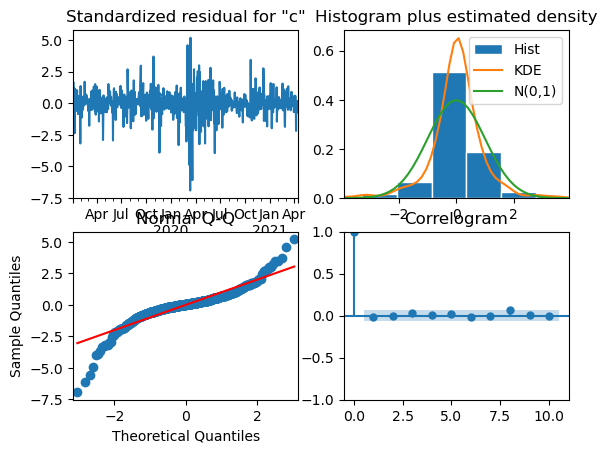

In [33]:
t_model_fit.plot_diagnostics()
plt.show()

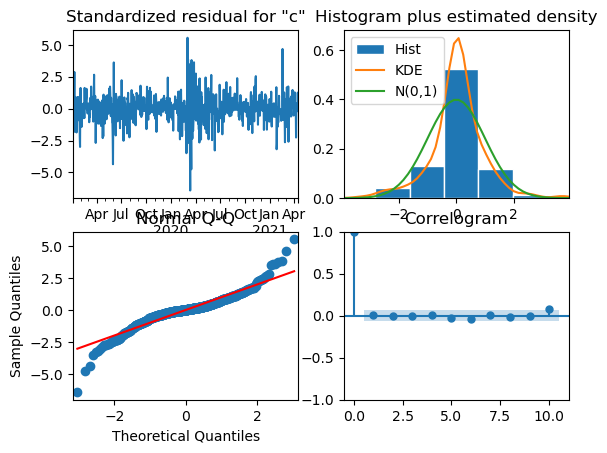

In [34]:
v_model_fit.plot_diagnostics()
plt.show()

In [35]:
# Check the residuals using the Ljung-Box test. 
# If p-values < 0.05, the residuals are not white noise.
from statsmodels.stats.diagnostic import acorr_ljungbox

t_residuals = t_model_fit.resid
v_residuals = v_model_fit.resid

print(f'AT&T Ljung-Box analysis, first 10 residuals:\n {acorr_ljungbox(t_residuals, lags=np.arange(1,11,1).tolist(), return_df=True)}')
print(f'Verizon Ljung-Box analysis, first 10 residuals:\n {acorr_ljungbox(v_residuals, lags=np.arange(1,11,1).tolist(), return_df=True)}')

AT&T Ljung-Box analysis, first 10 residuals:
      lb_stat  lb_pvalue
1   0.000189   0.989032
2   0.400746   0.818426
3   0.433936   0.933146
4   0.435416   0.979476
5   0.717701   0.981983
6   0.783485   0.992509
7   1.571371   0.979735
8   1.878297   0.984518
9   2.077681   0.990179
10  2.097464   0.995537
Verizon Ljung-Box analysis, first 10 residuals:
      lb_stat  lb_pvalue
1   0.009206   0.923562
2   0.014752   0.992651
3   0.014795   0.999524
4   0.015038   0.999972
5   0.025929   0.999994
6   0.531561   0.997433
7   0.780472   0.997638
8   0.810624   0.999185
9   0.863215   0.999693
10  0.883093   0.999903


In [36]:
# Predict the last 5% of the time series
assert len(t_arima_train) == len(v_arima_train)
pred_start = len(t_arima_train)
pred_end = len(t_arima_train) + len(t_test) - 1
t_arima_predictions = t_model_fit.predict(start=pred_start, end=pred_end, dynamic=False)
v_arima_predictions = v_model_fit.predict(start=pred_start, end=pred_end, dynamic=False)

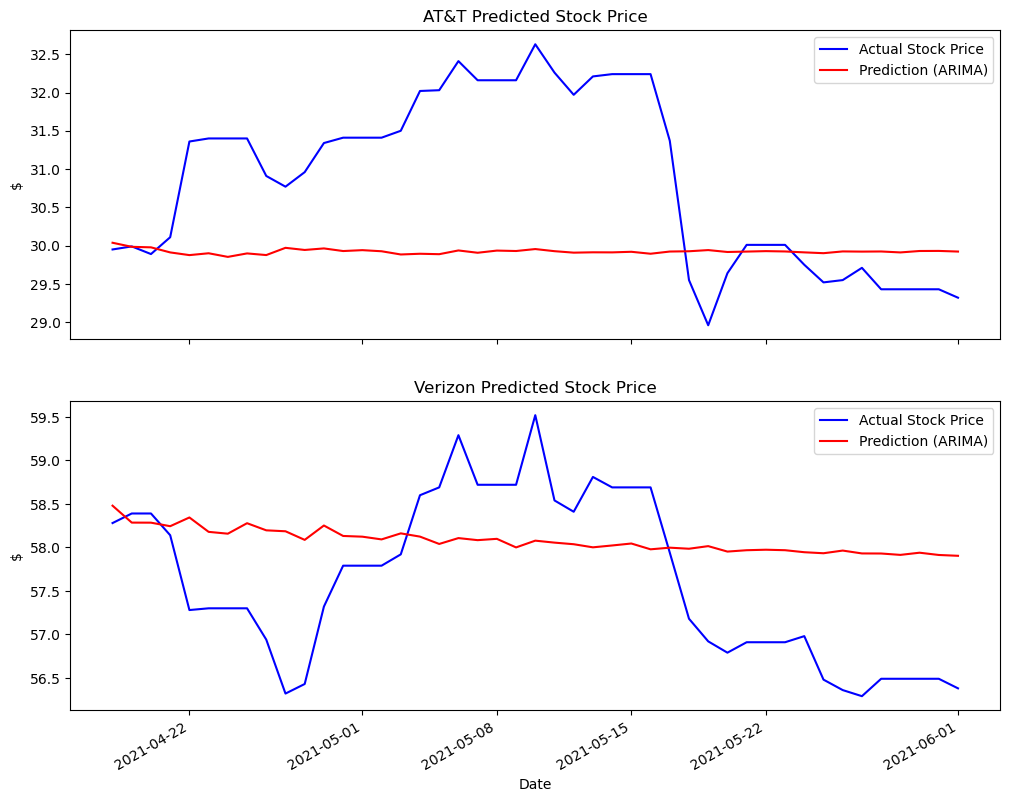

In [37]:
# Visualize the predictions
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 10))


ax1.plot(t_arima_test, label='Actual Stock Price', c='b')
ax1.plot(t_arima_predictions, c='r', label='Prediction (ARIMA)')
ax1.set_title('AT&T Predicted Stock Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('$')
ax1.legend(loc='best')

ax2.plot(v_arima_test, label='Actual Stock Price', c='b')
ax2.plot(v_arima_predictions, c='r', label='Prediction (ARIMA)')
ax2.set_title('Verizon Predicted Stock Price')
ax2.set_xlabel('Date')
ax2.set_ylabel('$')
ax2.legend(loc='best')

fig.autofmt_xdate()
plt.show()

In [38]:
print('RMSE of AT&T ARIMA model {:.4f}'
      .format(rmse(t_arima_test, t_arima_predictions)))
print('RMSE of Verizon ARIMA model {:.4f}'
      .format(rmse(v_arima_test, v_arima_predictions)))

RMSE of AT&T ARIMA model 1.4651
RMSE of Verizon ARIMA model 1.0108
